# RAG Chunking Optimization for Leaders

## Guide to Optimizing Retrieval Augmented Generation

**Author: Saumil Srivastava**  
**AI Engineering Consultant**

------------------------------------------------------------------------

##  Overview

This notebook demonstrates different text chunking strategies for
Retrieval Augmented Generation (RAG) systems, visualizing their
performance characteristics to help technical leaders make informed
architectural decisions.

The analysis focuses on: - How different chunking methods affect
retrieval quality - Performance and processing time implications -
Practical tradeoffs between methods to guide implementation decisions

------------------------------------------------------------------------

## 1. Setup and Configuration

### 1.1 Environment Preparation

In [35]:
# RAG Chunking Visualization for Technical Leaders

# Step 0: Install all required packages
# Added: faiss-cpu (for vector store), tiktoken (for token counting)
!pip install requests beautifulsoup4 pandas numpy matplotlib langchain langchain-community langchain-experimental langchain-text-splitters nltk spacy sentence-transformers llama-index-core llama-index-embeddings-huggingface faiss-cpu tiktoken

# Download NLTK and spaCy models
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

import spacy
try:
    spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy 'en_core_web_sm' model...")
    !python -m spacy download en_core_web_sm


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### 1.2 Imports and Dependencies


In [63]:
# --- IMPORTS ---
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import sent_tokenize
import spacy
import tiktoken # Added for token counting
import time # Added for timing strategies
import faiss # Added for vector store
from langchain_text_splitters import CharacterTextSplitter, RecursiveCharacterTextSplitter, MarkdownHeaderTextSplitter
from langchain_experimental.text_splitter import SemanticChunker
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS # Added
from llama_index.core.node_parser import SemanticSplitterNodeParser
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from llama_index.core import Document as LlamaDocument

### 1.3 Business Configuration


In [64]:
# --- CONFIGURATION ---
K8S_PODS_URL = "https://kubernetes.io/docs/concepts/workloads/pods/"
TARGET_CHUNK_SIZE_CHARS = 1000 # Target character count per chunk
CHUNK_OVERLAP_CHARS = 100    # Character overlap between chunks
EMBEDDING_MODEL_NAME = 'sentence-transformers/all-MiniLM-L6-v2'
TOKENIZER_NAME = 'cl100k_base' # Used by many OpenAI models, good general example for tiktoken

# Config for Token-Based Chunking
TARGET_CHUNK_SIZE_TOKENS = 256 # Example target token size
CHUNK_OVERLAP_TOKENS = 30     # Example token overlap

# Config for Retrieval Evaluation
SAMPLE_QUERIES = [
    "What is a Kubernetes Pod?",
    "How are containers grouped within a Pod?",
    "What is the basic lifecycle of a Pod?",
    "How is data shared between containers in a pod?",
]

# Set baseline for automated ground truth evaluation
BASELINE_STRATEGY_NAME = "Semantic (LangChain)"
AUTO_GROUND_TRUTH_TOP_N = 2
RETRIEVAL_K = 5 # Retrieve top K chunks for evaluation

------------------------------------------------------------------------

## 2. Data Acquisition & Preparation

### 2.1 Sample Document Processing

In [65]:
def fetch_and_prepare_data(url: str) -> str:
    """Fetches HTML from URL, extracts main text content, and injects a sample Markdown table."""
    try:
        response = requests.get(url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')
        main_content_element = soup.find('article') or soup.find('div', id='content') or soup.find('div', class_='content')

        if not main_content_element:
            print("Warning: Could not find main content element. Extracting all text.")
            document_text = soup.get_text(separator=' ', strip=True)
        else:
            document_text = main_content_element.get_text(separator=' ', strip=True)

        # --- Inject a sample Markdown table ---
        # For real-world testing with structured data
        injection_point = document_text.find("Pod Lifecycle") # Find a known header
        if injection_point == -1: injection_point = 5000 # Fallback if header not found

        sample_table = """

## Data Sharing Example (Injected Table)

Here's how data might be shared:

| Method          | Description                     | Use Case                  |
|-----------------|---------------------------------|---------------------------|
| **Volumes** | Filesystem shared among containers | Persistent data, configs  |
| **IPC Namespace** | Shared Inter-Process Comm       | Tightly coupled processes |
| **Network** | Shared localhost, Pod IP        | Service communication     |

This table summarizes common approaches.

"""
        document_text = document_text[:injection_point] + sample_table + document_text[injection_point:]

        print(f"Successfully fetched and extracted text from {url}")
        print(f"Document length: {len(document_text)} characters (incl. injected table)")
        return document_text

    except requests.exceptions.RequestException as e:
        print(f"Error fetching URL {url}: {e}")
        return ""
    except Exception as e:
        print(f"Error parsing HTML or injecting table: {e}")
        return ""

------------------------------------------------------------------------

## 3. Chunking Strategy Implementation

### 3.1 Traditional Character-Based Approaches

In [66]:
def chunk_fixed_size(text: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """Chunks text into fixed-size character chunks."""
    text_splitter = CharacterTextSplitter(
        separator="\n\n", # Less important here as it mainly cuts by length
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False,
    )
    docs = text_splitter.create_documents([text])
    return [doc.page_content for doc in docs]

def chunk_recursive(text: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """Chunks text recursively using multiple separators, including Markdown headers and code blocks."""
    # Added Markdown code blocks, paragraphs, sentences, words
    # Prioritize splitting larger structures first
    markdown_separators = [
        "\n## ", "\n### ", "\n#### ", # Headers
        "\n\n",                     # Paragraphs
        "\n",                       # Lines
        ". ", "!", "?",              # Sentences
        ", ", "; ",                 # Clauses/Phrases
        " ",                        # Words
        ""                          # Characters
    ]
    # Added common code block fences
    separators = ["\n```\n", "\n---", "\n***"] + RecursiveCharacterTextSplitter.get_separators_for_language("markdown") + markdown_separators

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=len,
        is_separator_regex=False,
        separators=separators,
    )
    docs = text_splitter.create_documents([text])
    return [doc.page_content for doc in docs]

### 3.2 Token-Based Approaches (LLM-Aware)


In [67]:
def chunk_tokens_recursive(text: str, tokenizer_name: str, chunk_size: int, chunk_overlap: int) -> list[str]:
    """Chunks text recursively based on token count."""
    try:
        tokenizer = tiktoken.get_encoding(tokenizer_name)
    except Exception as e:
        print(f"Error getting tokenizer '{tokenizer_name}': {e}. Falling back to character splitting.")
        # Fallback or raise error - let's fallback to character length for this example
        return chunk_recursive(text, chunk_size*4, chunk_overlap*4) # Rough approximation

    def token_length(text: str) -> int:
        return len(tokenizer.encode(text))

    # Use same separators as the enhanced recursive chunker
    markdown_separators = [
        "\n## ", "\n### ", "\n#### ", # Headers
        "\n\n",                     # Paragraphs
        "\n",                       # Lines
        ". ", "!", "?",              # Sentences
        ", ", "; ",                 # Clauses/Phrases
        " ",                        # Words
        ""                          # Characters
    ]
    separators = ["\n```\n", "\n---", "\n***"] + RecursiveCharacterTextSplitter.get_separators_for_language("markdown") + markdown_separators

    text_splitter = RecursiveCharacterTextSplitter(
        chunk_size=chunk_size,
        chunk_overlap=chunk_overlap,
        length_function=token_length, # Use token length function
        is_separator_regex=False,
        separators=separators,
    )
    docs = text_splitter.create_documents([text])
    return [doc.page_content for doc in docs]

### 3.3 NLP-Based Approaches


In [68]:
def chunk_sentences_nltk(text: str, target_chunk_size: int) -> list[str]:
    """Chunks text by sentences (NLTK) and groups them."""
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = ""
    for sentence in sentences:
        if not current_chunk or len(current_chunk) + len(sentence) + 1 <= target_chunk_size * 1.2: # Allow some overshoot
            current_chunk += (" " + sentence).strip()
        else:
            chunks.append(current_chunk)
            current_chunk = sentence
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

def chunk_sentences_spacy(text: str, target_chunk_size: int) -> list[str]:
    """Chunks text by sentences (spaCy) and groups them."""
    try:
        nlp = spacy.load("en_core_web_sm")
    except OSError:
        print("Downloading spaCy 'en_core_web_sm' model...")
        spacy.cli.download("en_core_web_sm")
        nlp = spacy.load("en_core_web_sm")
    if len(text) > nlp.max_length:
        nlp.max_length = len(text) + 100
    doc = nlp(text)
    sentences = [sent.text for sent in doc.sents]
    chunks = []
    current_chunk = ""
    for sentence in sentences:
        if not current_chunk or len(current_chunk) + len(sentence) + 1 <= target_chunk_size * 1.2: # Allow overshoot
            current_chunk += (" " + sentence).strip()
        else:
            chunks.append(current_chunk)
            current_chunk = sentence
    if current_chunk:
        chunks.append(current_chunk)
    return chunks

### 3.4 Advanced Semantic Approaches


In [69]:
def chunk_semantic_langchain(text: str, embedding_model_name: str, threshold_type: str = "percentile", threshold_amount: float = 0.95) -> list[str]:
    """Chunks text semantically using LangChain's SemanticChunker."""
    try:
        embeddings = HuggingFaceEmbeddings(model_name=embedding_model_name)
        text_splitter = SemanticChunker(
            embeddings=embeddings,
            breakpoint_threshold_type=threshold_type,
            breakpoint_threshold_amount=threshold_amount
        )
        docs = text_splitter.create_documents([text])
        return [doc.page_content for doc in docs]
    except Exception as e:
        print(f"Error during LangChain Semantic Chunking: {e}")
        return []

def chunk_semantic_llamaindex(text: str, embedding_model_name: str, threshold: int = 95, buffer_size: int = 1) -> list[str]:
    """Chunks text semantically using LlamaIndex's SemanticSplitterNodeParser."""
    try:
        embed_model_li = HuggingFaceEmbedding(model_name=embedding_model_name)
        splitter = SemanticSplitterNodeParser(
            buffer_size=buffer_size,
            breakpoint_percentile_threshold=threshold,
            embed_model=embed_model_li,
        )
        llama_doc = LlamaDocument(text=text)
        nodes = splitter.get_nodes_from_documents([llama_doc])
        return [node.get_content() for node in nodes]
    except Exception as e:
        print(f"Error during LlamaIndex Semantic Chunking: {e}")
        return []

### 3.5 Structure-Aware Approaches


In [70]:
def chunk_markdown_header(text: str) -> list[str]:
    """Chunks text based on Markdown headers."""
    headers_to_split_on = [("#", "H1"), ("##", "H2"), ("###", "H3"), ("####", "H4")]
    markdown_splitter = MarkdownHeaderTextSplitter(
        headers_to_split_on=headers_to_split_on,
        strip_headers=True
    )
    try:
        # Check if the text actually contains markdown headers we split on
        has_headers = any(header[0] in text for header in headers_to_split_on)
        if not has_headers:
             # Add a dummy header if no real headers are found matching the splitters
             print("No markdown headers found matching split levels. Adding a dummy header.")
             text_with_header = "# Document\n\n" + text
             md_header_splits = markdown_splitter.split_text(text_with_header)
        else:
             md_header_splits = markdown_splitter.split_text(text)

        if not md_header_splits: # Still might be empty if text is very short or only has headers
             print("Warning: Markdown splitting resulted in zero chunks.")
             # Return the original text as one chunk? Or empty list? Let's return empty.
             return []

        return [split.page_content for split in md_header_splits if split.page_content.strip()] # Ensure no empty chunks
    except Exception as e:
        print(f"Error during Markdown Header Chunking: {e}")
        return []

------------------------------------------------------------------------

## 4. Performance Analysis & Metrics

### 4.1 Statistics Collection Function

In [71]:
def collect_statistics(strategy_name: str, chunks: list[str], duration: float) -> dict:
    """Calculates chunk count, lengths, and includes processing time."""
    chunk_count = len(chunks)
    if chunk_count == 0:
        chunk_lengths = []
        min_len, max_len, mean_len, std_len = 0, 0, 0, 0
    else:
        chunk_lengths = [len(chunk) for chunk in chunks]
        min_len = min(chunk_lengths)
        max_len = max(chunk_lengths)
        mean_len = np.mean(chunk_lengths)
        std_len = np.std(chunk_lengths)

    return {
        "Strategy": strategy_name,
        "ChunkCount": chunk_count,
        "ChunkLengths": chunk_lengths,
        "MinLength": min_len,
        "MaxLength": max_len,
        "MeanLength": mean_len,
        "StdDevLength": std_len,
        "Duration": duration, # Added duration
    }

### 4.2 Retrieval Quality Evaluation Function


In [72]:
def evaluate_retrieval_quality(strategy_name: str, chunks: list[str], embedding_model: HuggingFaceEmbeddings, queries: list[str], ground_truth_map: dict, k: int) -> dict:
    """Evaluates retrieval quality for a set of chunks."""
    if not chunks:
        return {"Strategy": strategy_name, "HitRate": 0, "MRR": 0, "AvgRetrievedLength": 0, "Notes": "No chunks"}

    print(f"  Evaluating retrieval for {strategy_name}...")
    try:
        # 1. Embed chunks
        print(f"    Embedding {len(chunks)} chunks...")
        start_embed_time = time.time()
        chunk_embeddings = embedding_model.embed_documents(chunks)
        print(f"    Embedding took {time.time() - start_embed_time:.2f}s")

        # Check for embedding dimension mismatch or errors
        if not chunk_embeddings or len(chunk_embeddings) != len(chunks):
             print(f"    Error: Number of embeddings ({len(chunk_embeddings) if chunk_embeddings else 0}) doesn't match number of chunks ({len(chunks)}).")
             return {"Strategy": strategy_name, "HitRate": 0, "MRR": 0, "AvgRetrievedLength": 0, "Notes": "Embedding mismatch"}

        # 2. Build FAISS index
        print(f"    Building FAISS index...")
        # Ensure embeddings are float32 numpy arrays
        embeddings_np = np.array(chunk_embeddings).astype('float32')
        dimension = embeddings_np.shape[1]
        index = faiss.IndexFlatL2(dimension) # Using L2 distance (equivalent to cosine similarity for normalized embeddings)
        index.add(embeddings_np)

        # 3. Embed queries
        query_embeddings = embedding_model.embed_documents(queries)
        query_embeddings_np = np.array(query_embeddings).astype('float32')

        # 4. Perform search and evaluate
        total_hits = 0
        reciprocal_ranks = []
        retrieved_lengths = []
        retrieved_chunk_details = {} # Store retrieved chunks per query for inspection

        print(f"    Performing search for {len(queries)} queries...")
        for i, query_embedding in enumerate(query_embeddings_np):
            # FAISS returns distances and indices
            distances, indices = index.search(np.array([query_embedding]), k)
            retrieved_indices = indices[0] # Get the list of indices for this query

            # Store retrieved content for inspection
            retrieved_chunk_details[queries[i]] = [chunks[idx][:150] + "..." for idx in retrieved_indices if idx != -1] # idx=-1 if less than k results

            # Evaluate based on ground truth (simple exact match for this example)
            hit = 0
            first_hit_rank = 0
            ideal_indices = ground_truth_map.get(i, []) # Get ideal chunk indices for this query

            for rank, retrieved_idx in enumerate(retrieved_indices):
                if retrieved_idx in ideal_indices:
                    hit = 1
                    if first_hit_rank == 0:
                        first_hit_rank = rank + 1
                    # Optional: break here if only interested in first hit
            total_hits += hit
            reciprocal_ranks.append(1 / first_hit_rank if first_hit_rank > 0 else 0)

            # Calculate average length of retrieved chunks for this query
            query_retrieved_lengths = [len(chunks[idx]) for idx in retrieved_indices if idx != -1]
            if query_retrieved_lengths:
                retrieved_lengths.append(np.mean(query_retrieved_lengths))

        hit_rate = total_hits / len(queries) if queries else 0
        mrr = np.mean(reciprocal_ranks) if reciprocal_ranks else 0
        avg_retrieved_len = np.mean(retrieved_lengths) if retrieved_lengths else 0

        print(f"    Evaluation complete: HitRate={hit_rate:.2f}, MRR={mrr:.2f}")

        return {
            "Strategy": strategy_name,
            "HitRate": hit_rate,
            "MRR": mrr,
            "AvgRetrievedLength": avg_retrieved_len,
            "RetrievedChunks": retrieved_chunk_details, # Include sample retrieved chunks
            "Notes": ""
        }

    except Exception as e:
        print(f"  Error during retrieval evaluation for {strategy_name}: {e}")
        import traceback
        traceback.print_exc() # Print full traceback for debugging
        return {"Strategy": strategy_name, "HitRate": 0, "MRR": 0, "AvgRetrievedLength": 0, "Notes": f"Evaluation Error: {e}"}

### 4.3 Sample Analysis Function


In [73]:
def print_sample_chunks(strategy_name: str, chunks: list[str], num_samples: int = 3, sample_len: int = 200):
    """Prints the beginning of the first few chunks and checks for injected table."""
    print(f"\n--- Sample Chunks: {strategy_name} (First {min(num_samples, len(chunks))}) ---")
    if not chunks:
        print("  No chunks generated.")
        return

    found_table_chunk = -1
    for i, chunk in enumerate(chunks[:num_samples]):
        chunk_content = str(chunk)
        print(f"  Chunk {i+1} (Length: {len(chunk_content)}): {chunk_content[:sample_len]}...")
        # Check if the injected table header appears in this chunk
        if "Data Sharing Example (Injected Table)" in chunk_content:
            found_table_chunk = i + 1

    # Print note about table handling
    if found_table_chunk != -1:
        print(f"  [Note: Injected table content found in sample Chunk {found_table_chunk}]")
    else:
        # Check later chunks if not found in first few samples
        table_found_later = False
        for i, chunk in enumerate(chunks[num_samples:]):
             if "Data Sharing Example (Injected Table)" in str(chunk):
                  print(f"  [Note: Injected table content found later, in Chunk {i + num_samples + 1}]")
                  table_found_later = True
                  break
        if not table_found_later:
             print(f"  [Note: Injected table content not found in analyzed chunks]")

    print("-" * (len(strategy_name) + 24)) # Separator line

------------------------------------------------------------------------

## 5. Visualizations

### 5.1 Histogram Visualization

In [74]:
def plot_histograms(stats_df: pd.DataFrame):
    """Plots histograms of chunk lengths for each strategy in a more readable format."""
    num_strategies = len(stats_df)
    if num_strategies == 0:
        print("No statistics available to plot histograms.")
        return

    # Create subplots in a grid format (more vertical space per plot)
    # Determine number of rows and columns for a grid layout
    n_cols = 2 # Display 2 strategies per row
    n_rows = (num_strategies + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    fig.suptitle("Distribution of Chunk Lengths by Strategy", fontsize=16, y=1.02)


    # Flatten axes if it's a multi-dimensional array
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes] # Make it a list for single plot case

    # Loop through strategies and plot histograms
    for i, (_, row) in enumerate(stats_df.iterrows()):
        if i < len(axes): # Ensure we have an axis for this strategy
            ax = axes[i]
            ax.set_facecolor('white') # White background for plot area

            if row['ChunkCount'] > 0:
                # Calculate better bin width based on data distribution
                chunks = row['ChunkLengths']
                if max(chunks) - min(chunks) > 0:
                    bin_width = (max(chunks) - min(chunks)) / 20 # Using ~20 bins
                    bins = np.arange(min(chunks), max(chunks) + bin_width, bin_width)
                else:
                    bins = 'auto'

                # Use brand colors
                ax.hist(row['ChunkLengths'], bins=bins, alpha=0.7, linewidth=1)

                # Add mean line with brand color
                mean_len = row['MeanLength']
                ax.axvline(mean_len, linestyle='dashed', linewidth=2,
                           label=f'Mean: {mean_len:.0f} chars')

                # Add target size line (if applicable)
                # Check includes the relevant strategies that use the character target size
                if 'Fixed-Size' in row['Strategy'] or 'Recursive' in row['Strategy'] or 'NLTK Sentence' in row['Strategy'] or 'spaCy Sentence' in row['Strategy']:
                    ax.axvline(TARGET_CHUNK_SIZE_CHARS, linestyle='dotted', linewidth=1.5,
                               label=f'Target: {TARGET_CHUNK_SIZE_CHARS} chars')

                # Add more clear labels with brand colors
                ax.set_title(f"{row['Strategy']} (N={row['ChunkCount']})", fontsize=12,
                             fontweight='bold')
                ax.set_xlabel("Chunk Length (Characters)", fontsize=10)
                ax.set_ylabel("Frequency", fontsize=10)

                # Add grid for better readability
                ax.grid(axis='y', alpha=0.3)

                # Add legend with brand styling
                legend = ax.legend(frameon=True, facecolor='white')


                # Add statistics annotations with brand styling
                sorted_chunks = sorted(row['ChunkLengths'])
                if len(sorted_chunks) > 0:
                    q1, q3 = np.percentile(sorted_chunks, [25, 75])
                    iqr = q3 - q1
                    ax.annotate(f"Min: {min(sorted_chunks)}\nMax: {max(sorted_chunks)}\nIQR: {iqr:.0f}",
                                xy=(0.05, 0.95), xycoords='axes fraction',
                                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9),
                                ha='left', va='top', fontsize=9)
            else:
                ax.set_title(f"{row['Strategy']} (No chunks)", fontsize=12)
                ax.text(0.5, 0.5, 'No Chunks', horizontalalignment='center',
                        verticalalignment='center', transform=ax.transAxes)

    # Hide empty subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

### 5.2 Comparative Boxplots


In [75]:
def plot_boxplots(stats_df: pd.DataFrame):
    """Plots an improved box plot comparing chunk length distributions across strategies."""
    # Explode the DataFrame to have one row per chunk length
    try:
        # Ensure ChunkLengths is not empty before exploding
        plot_data = stats_df[stats_df['ChunkLengths'].apply(len) > 0].explode('ChunkLengths')
        plot_data['ChunkLengths'] = plot_data['ChunkLengths'].astype(int)
    except Exception as e:
        print(f"Could not prepare data for box plot: {e}")
        return

    if plot_data.empty:
        print("No data available for box plot.")
        return

    fig, ax = plt.subplots(figsize=(14, 8))
    ax.set_facecolor('white')


    # Create a colorful, more visually appealing boxplot
    boxplot = ax.boxplot(
        [stats_df.iloc[i]['ChunkLengths'] for i in range(len(stats_df)) if len(stats_df.iloc[i]['ChunkLengths']) > 0],
        patch_artist=True, # Fill boxes with color
        notch=True, # Add notch to boxplot
        vert=True,   # Vertical orientation
        widths=0.6, # Make boxes wider
        showfliers=True # Show outliers
    )

    # Customize boxplot colors and appearance
    for i, patch in enumerate(boxplot['boxes']):
        patch.set_alpha(0.7)

    for element in ['whiskers', 'caps']:
        for item in boxplot[element]:
            item.set_linewidth(1.5)

    for item in boxplot['medians']:
        item.set_linewidth(2)

    for item in boxplot['fliers']:
        item.set_alpha(0.6)

    # Add strategy names as x-tick labels
    strategies = [row['Strategy'] for _, row in stats_df.iterrows() if len(row['ChunkLengths']) > 0]
    ax.set_xticks(range(1, len(strategies) + 1))
    ax.set_xticklabels(strategies, rotation=30, ha='right', fontsize=11, fontweight='bold')

    # Add mean values as points
    means = [np.mean(row['ChunkLengths']) for _, row in stats_df.iterrows() if len(row['ChunkLengths']) > 0]
    ax.scatter(range(1, len(means) + 1), means, s=80, marker='D', label='Mean', zorder=10)

    # Add target size reference line
    ax.axhline(TARGET_CHUNK_SIZE_CHARS, linestyle='--', alpha=0.7,
               label=f'Target Size: {TARGET_CHUNK_SIZE_CHARS}')

    # Add clear labels and title
    ax.set_ylabel('Chunk Length (Characters)', fontsize=12, fontweight='bold')
    ax.set_title('Comparison of Chunk Length Distributions', fontsize=16, fontweight='bold', pad=20)

    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5,)

    # Add legend with brand styling
    legend = ax.legend(fontsize=10, frameon=True, facecolor='white', )


    # Annotate with some statistics
    for i, (mean, strategy) in enumerate(zip(means, strategies)):
        ax.annotate(f"Mean: {mean:.0f}",
                    xy=(i+1, mean),
                    xytext=(0, 10),
                    textcoords='offset points',
                    ha='center', va='bottom',
                    fontsize=9,
                    bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.9))

    plt.tight_layout()
    plt.show()

### 5.3 Strategy Comparison: Length, Count, and Duration


In [76]:
def plot_strategy_comparison(stats_df: pd.DataFrame):
    """Creates a bar chart comparing key metrics (Mean Length, Count, Duration) across chunking strategies."""
    if stats_df.empty:
        print("No data available for strategy comparison.")
        return

    # Create a figure with three subplots now
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 7)) # Wider figure
    ax1.set_facecolor('white'); ax2.set_facecolor('white'); ax3.set_facecolor('white')

    valid_df = stats_df[stats_df['ChunkCount'] > 0].copy()
    if valid_df.empty:
        print("No valid strategies with chunks to compare.")
        return
    valid_df = valid_df.sort_values('MeanLength', ascending=False)
    strategies = valid_df['Strategy']

    # Plot 1: Mean chunk lengths with std dev
    means = valid_df['MeanLength']
    stds = valid_df['StdDevLength']
    bars1 = ax1.barh(strategies, means, xerr=stds, alpha=0.8, error_kw={ 'capsize': 5})

    for i, bar in enumerate(bars1):
         width = bar.get_width(); std = stds.iloc[i]
         ax1.text(width + std + 5, bar.get_y() + bar.get_height()/2, f'{width:.0f} ± {std:.0f}', va='center', ha='left', fontsize=8) # Adjusted label position
    ax1.axvline(TARGET_CHUNK_SIZE_CHARS, linestyle='--', alpha=0.7, label=f'Target Chars: {TARGET_CHUNK_SIZE_CHARS}')
    ax1.set_xlabel('Mean Chunk Length (Chars)', fontsize=11)
    ax1.set_title('Mean Chunk Length', fontsize=13, fontweight='bold')
    ax1.tick_params(axis='x', labelsize=9); ax1.tick_params(axis='y', labelsize=9)
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    legend1 = ax1.legend(frameon=True, facecolor='white', fontsize=8)

    # Plot 2: Chunk count comparison
    counts = valid_df['ChunkCount']

    bars2 = ax2.barh(strategies, counts, alpha=0.8)

    for bar in bars2:
         width = bar.get_width()
         ax2.text(width + 0.2, bar.get_y() + bar.get_height()/2, f'{width:.0f}', va='center', ha='left', fontsize=9) # Adjusted label position
    ax2.set_xlabel('Number of Chunks', fontsize=11)
    ax2.set_title('Chunk Count', fontsize=13, fontweight='bold')
    ax2.tick_params(axis='x', labelsize=9); ax2.tick_params(axis='y', labelleft=False) # Hide y-labels
    ax2.grid(axis='x', linestyle='--', alpha=0.5)

    # Plot 3: Duration comparison
    durations = valid_df['Duration']
    bars3 = ax3.barh(strategies, durations, alpha=0.8)
    for bar in bars3:
         width = bar.get_width()
         ax3.text(width + 0.05 * durations.max(), bar.get_y() + bar.get_height()/2, f'{width:.2f}s', va='center', ha='left', fontsize=9) # Adjusted label position
    ax3.set_xlabel('Processing Time (seconds)', fontsize=11)
    ax3.set_title('Chunking Duration', fontsize=13, fontweight='bold')
    ax3.tick_params(axis='x', labelsize=9); ax3.tick_params(axis='y', labelleft=False) # Hide y-labels
    ax3.grid(axis='x', linestyle='--', alpha=0.5)

    fig.suptitle('Chunking Strategy Comparison: Length, Count, and Duration', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

### 5.4 Chunk Size Variation Analysis


In [77]:
def plot_chunk_size_variation(stats_df: pd.DataFrame):
    """Creates a visualization showing how the chunk sizes vary within each strategy."""
    if stats_df.empty or all(len(row['ChunkLengths']) == 0 for _, row in stats_df.iterrows()):
        print("No chunk data available for size variation plot.")
        return

    # Create figure
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.set_facecolor('white')

    # Get strategies with chunks
    valid_strategies = []
    data_to_plot = []

    for _, row in stats_df.iterrows():
        if len(row['ChunkLengths']) > 0:
            valid_strategies.append(row['Strategy'])
            data_to_plot.append(row['ChunkLengths'])

    if not valid_strategies:
        print("No valid strategies with chunks found.")
        return

    # Create violin plot with brand colors
    parts = ax.violinplot(data_to_plot, showmedians=True, showextrema=True)

    # Customize violin plots with brand colors
    for i, pc in enumerate(parts['bodies']):
        pc.set_alpha(0.7)

    # Customize other elements
    for partname in ['cbars', 'cmins', 'cmaxes']:
        parts[partname].set_linewidth(1.5)

    parts['cmedians'].set_linewidth(2)

    # Add target chunk size line
    ax.axhline(y=TARGET_CHUNK_SIZE_CHARS, linestyle='--',
               alpha=0.8, label=f'Target Size: {TARGET_CHUNK_SIZE_CHARS}')

    # Set axis labels and title
    ax.set_ylabel('Chunk Size (Characters)', fontsize=12, fontweight='bold')
    ax.set_title('Variation in Chunk Sizes Across Strategies', fontsize=14, fontweight='bold')

    # Set x-ticks to strategy names
    ax.set_xticks(range(1, len(valid_strategies) + 1))
    ax.set_xticklabels(valid_strategies, rotation=30, ha='right')

    # Add grid for better readability
    ax.grid(axis='y', linestyle='--', alpha=0.5)

    # Add jittered points to see actual data distribution
    for i, lengths in enumerate(data_to_plot):
        # Add jitter to x-position
        jitter = np.random.normal(0, 0.07, size=len(lengths))
        x_pos = np.full_like(lengths, i + 1) + jitter
        ax.scatter(x_pos, lengths, alpha=0.3, s=15)

    # Add legend with brand styling
    legend = ax.legend(frameon=True, facecolor='white')


    plt.tight_layout()
    plt.show()

### 5.5 Retrieval Quality Comparison


In [78]:
def plot_retrieval_comparison(retrieval_df: pd.DataFrame):
    """Creates a bar chart comparing retrieval metrics (HitRate, MRR) across chunking strategies."""
    valid_df = retrieval_df[retrieval_df['Notes'] == ''].copy()
    if retrieval_df.empty:
        print("No retrieval data available for comparison.")
        return

    # Filter out strategies with errors
    valid_df = retrieval_df[retrieval_df['Notes'] == ''].copy()
    if valid_df.empty:
        print("No valid retrieval results (without errors) to compare.")
        return

    # Sort by MRR for better visualization
    valid_df = valid_df.sort_values('MRR', ascending=False)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6)) # Two plots: HitRate, MRR
    ax1.set_facecolor('white'); ax2.set_facecolor('white')
    strategies = valid_df['Strategy']

    # Plot 1: Hit Rate
    hit_rates = valid_df['HitRate']
    bars1 = ax1.barh(strategies, hit_rates, alpha=0.8)
    ax1.set_xlabel('Hit Rate@' + str(RETRIEVAL_K), fontsize=11)
    ax1.set_title('Retrieval Hit Rate', fontsize=13, fontweight='bold')
    ax1.set_xlim(0, 1.05) # Hit rate is between 0 and 1
    ax1.tick_params(axis='x', labelsize=9); ax1.tick_params(axis='y', labelsize=9)
    ax1.grid(axis='x', linestyle='--', alpha=0.5)
    for bar in bars1:
        width = bar.get_width()
        ax1.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='left', fontsize=9)

    # Plot 2: MRR
    mrrs = valid_df['MRR']
    bars2 = ax2.barh(strategies, mrrs, alpha=0.8)
    ax2.set_xlabel('Mean Reciprocal Rank (MRR)@' + str(RETRIEVAL_K), fontsize=11)
    ax2.set_title('Retrieval MRR', fontsize=13, fontweight='bold')
    ax2.set_xlim(0, 1.05) # MRR is between 0 and 1
    ax2.tick_params(axis='x', labelsize=9); ax2.tick_params(axis='y', labelleft=False) # Hide y-labels
    ax2.grid(axis='x', linestyle='--', alpha=0.5)
    for bar in bars2:
        width = bar.get_width()
        ax2.text(width + 0.01, bar.get_y() + bar.get_height()/2, f'{width:.2f}', va='center', ha='left', fontsize=9)

    fig.suptitle('Retrieval Quality Comparison', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

------------------------------------------------------------------------

## 6. Main Execution Logic

### 6.1 Automated Ground Truth Generation

Successfully fetched and extracted text from https://kubernetes.io/docs/concepts/workloads/pods/
Document length: 40535 characters (incl. injected table)

Loading embedding model: sentence-transformers/all-MiniLM-L6-v2...
Embedding model loaded in 0.82s

--- Generating Automated Ground Truth using Baseline: Semantic (LangChain) ---
  Running baseline chunking (Semantic (LangChain))...
  Generated 157 baseline chunks.
  Embedding baseline chunks...


  Building FAISS index for baseline...
  Embedding queries...
  Searching baseline chunks to generate ground truth map (Top 2)...
  Automated ground truth map generated.
  Generated Map: {0: [7, 144], 1: [17, 15], 2: [141, 7], 3: [90, 88]}

>>> Processing: Fixed-Size <<<
  Completed in 0.00 seconds.
  Generated 3 chunks.

--- Sample Chunks: Fixed-Size (First 3) ---
  Chunk 1 (Length: 1651): Pods | Kubernetes Pods | Kubernetes Kubernetes Documentation Kubernetes Blog Training Partners Community Case Studies Versions Release Information v1.33 v1.32 v1.31 v1.30 v1.29 English বাংলা (Bengali)...
  Chunk 2 (Length: 524): ## Data Sharing Example (Injected Table)

Here's how data might be shared:

| Method          | Description                     | Use Case                  |
|-----------------|-----------------------...
  Chunk 3 (Length: 38355): Pod Lifecycle Init Containers Sidecar Containers Ephemeral Containers Disruptions Pod Quality of Service Classes User Namespaces Downward API Work

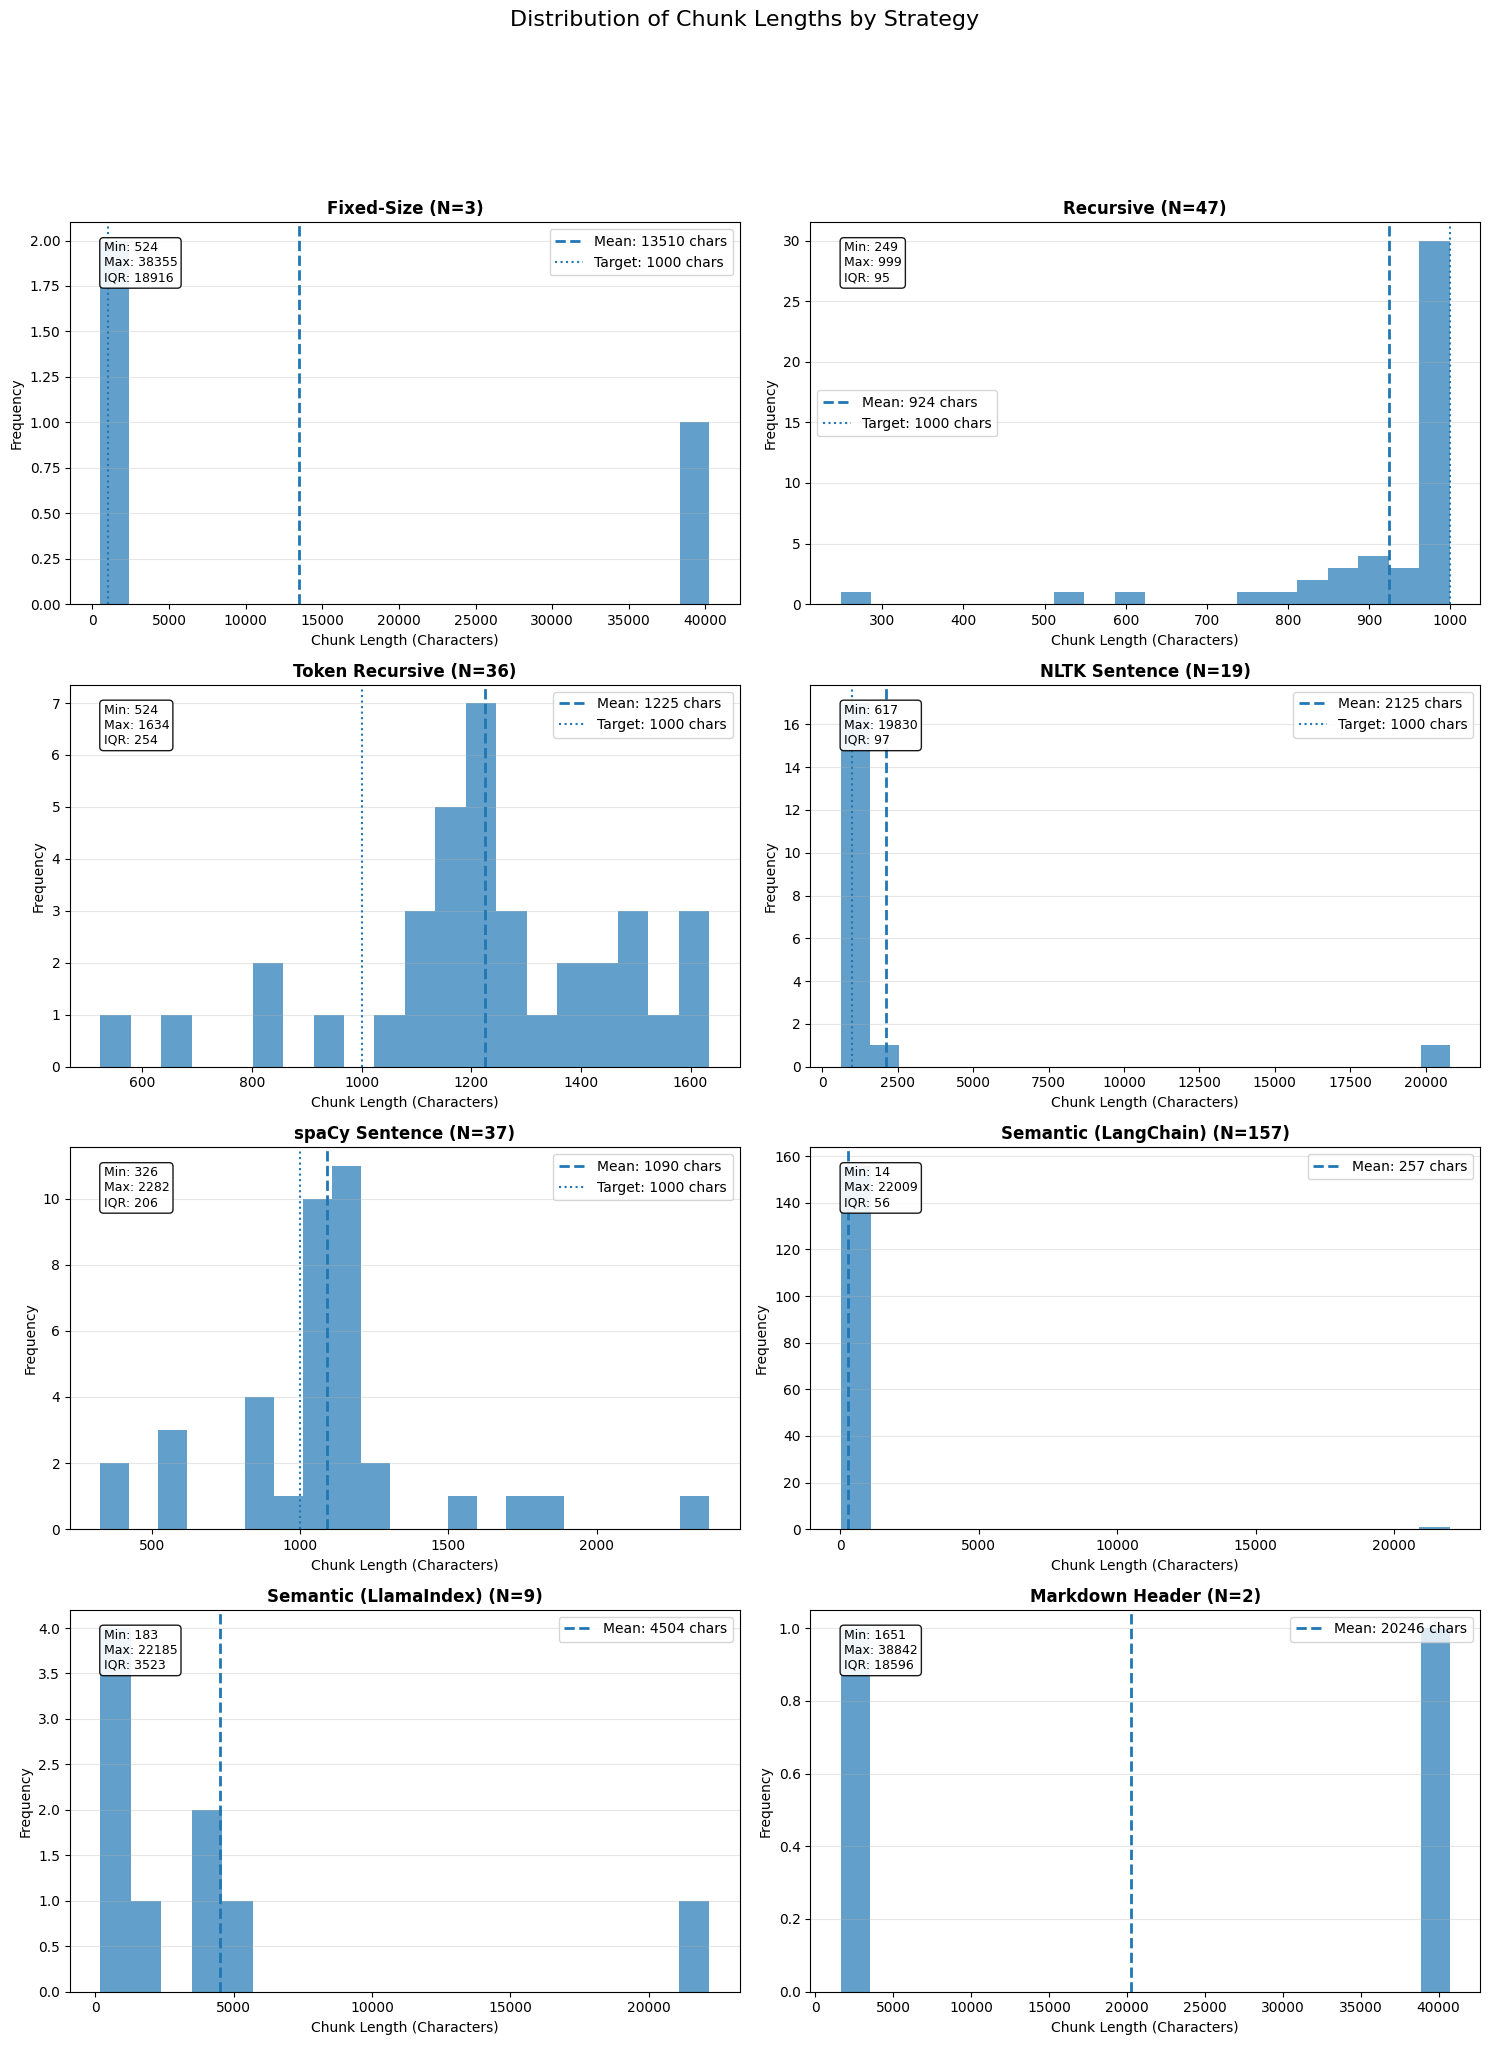


Generating chunk statistics box plots...


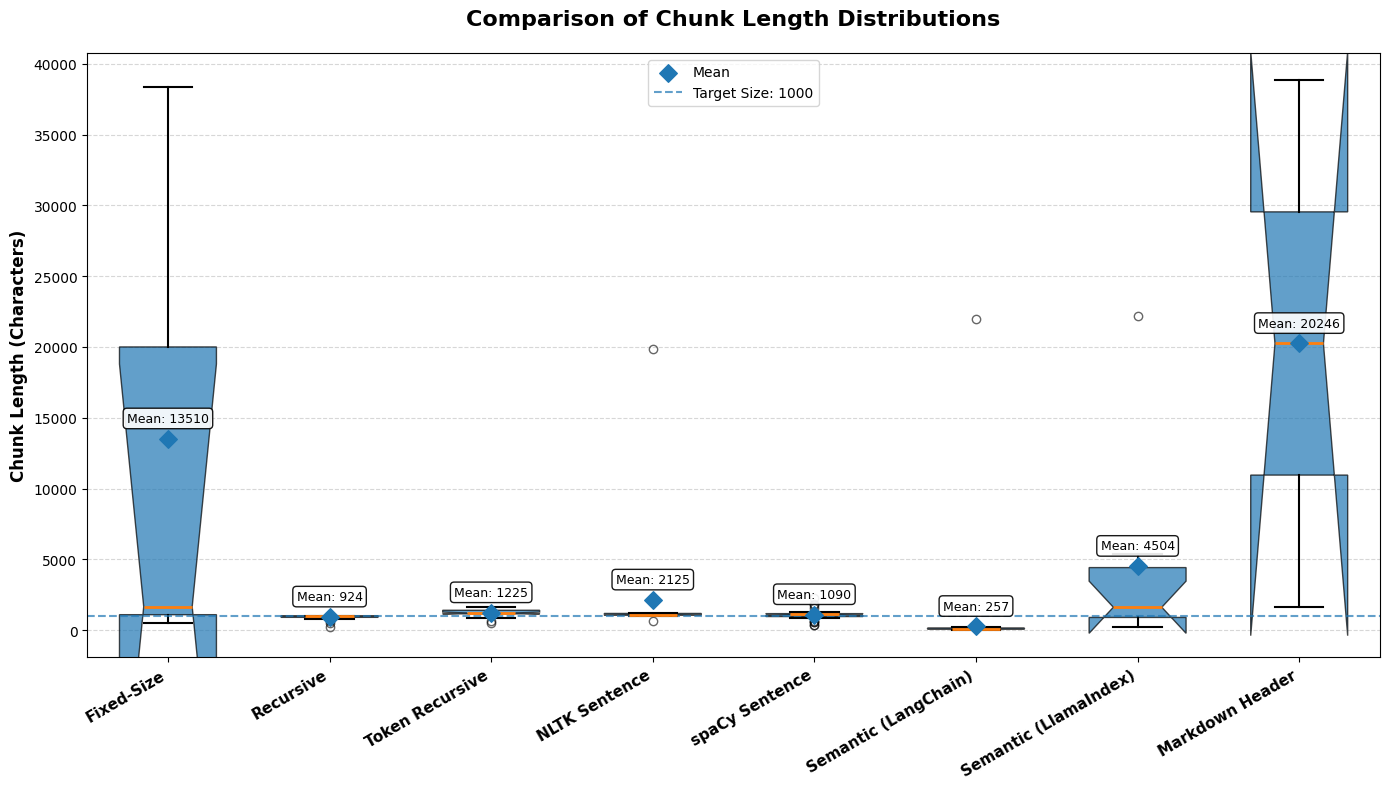


Generating strategy comparison plots (Length, Count, Duration)...


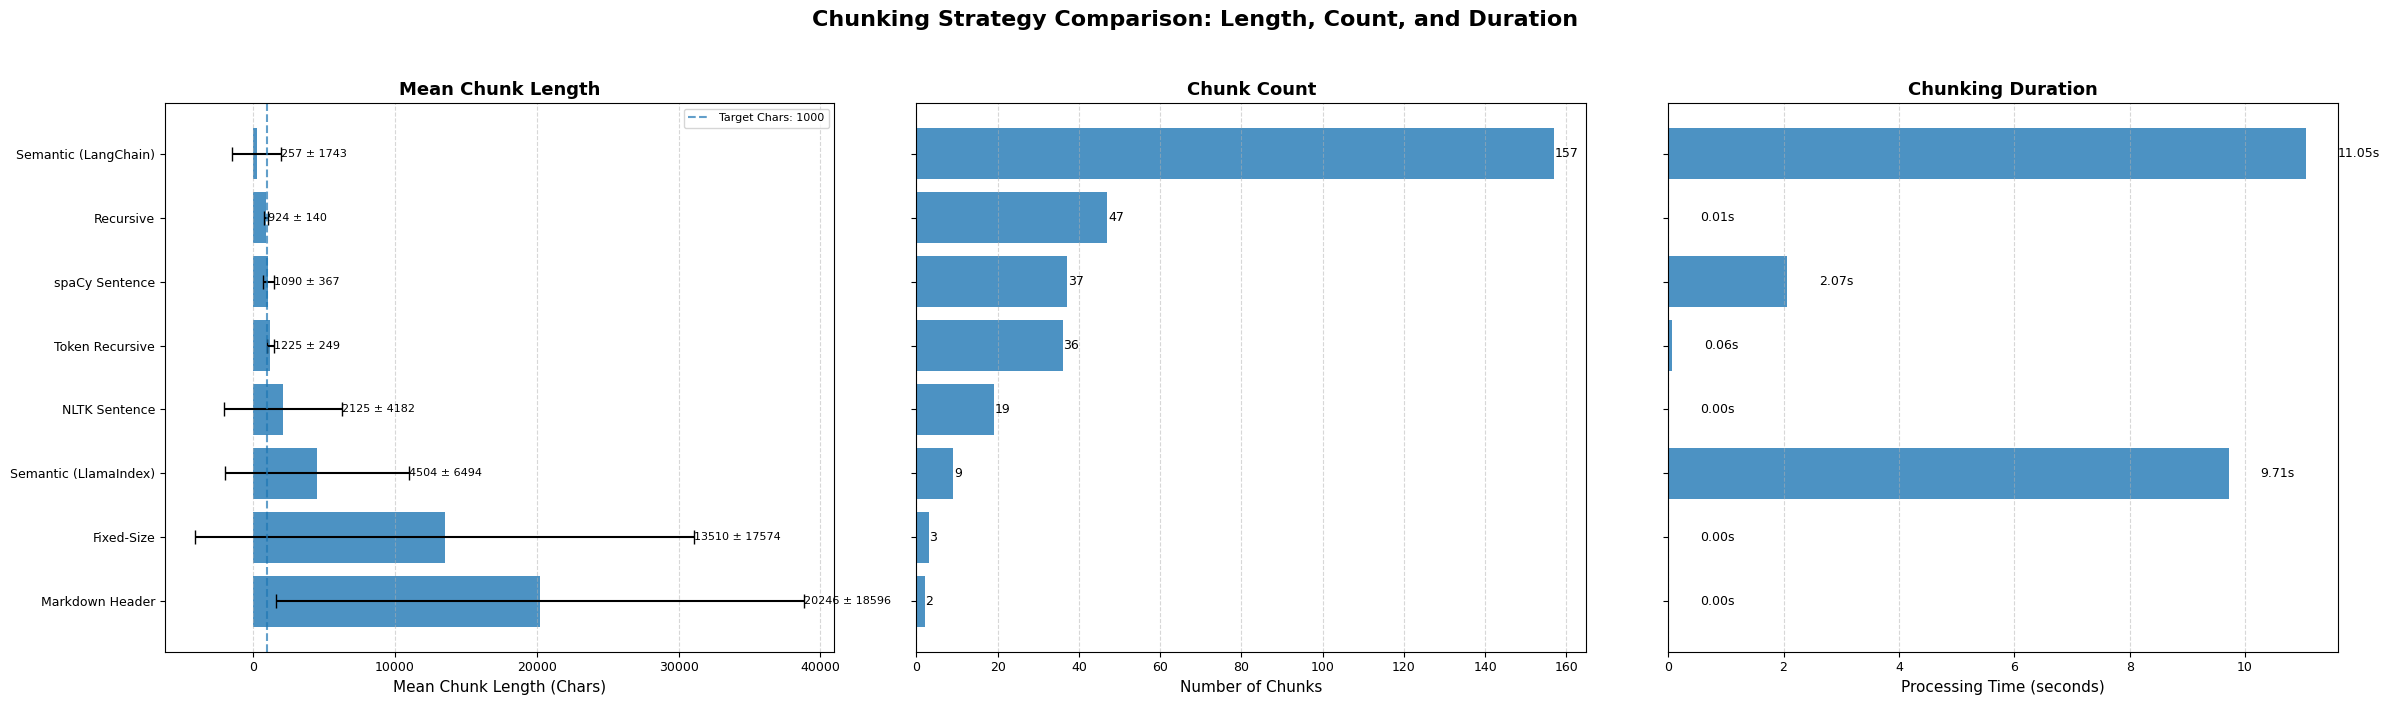


Generating chunk size variation plots...


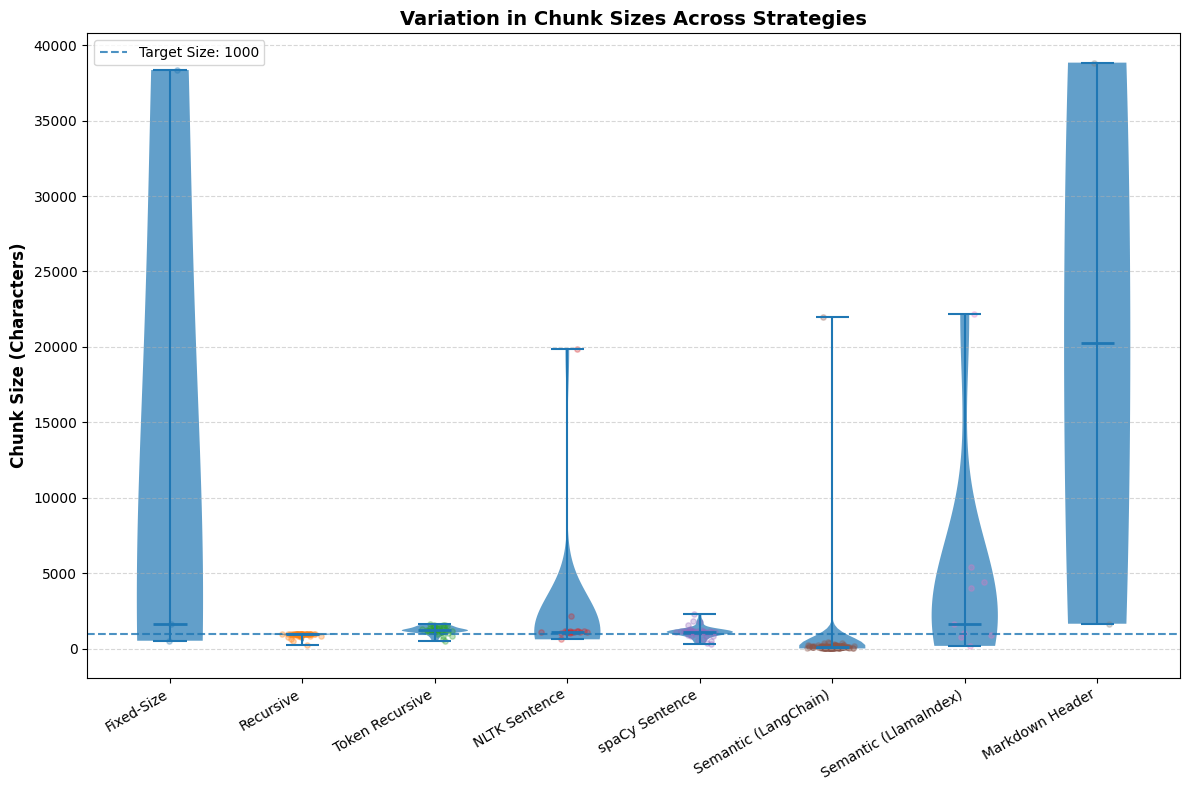


Generating retrieval quality comparison plots...


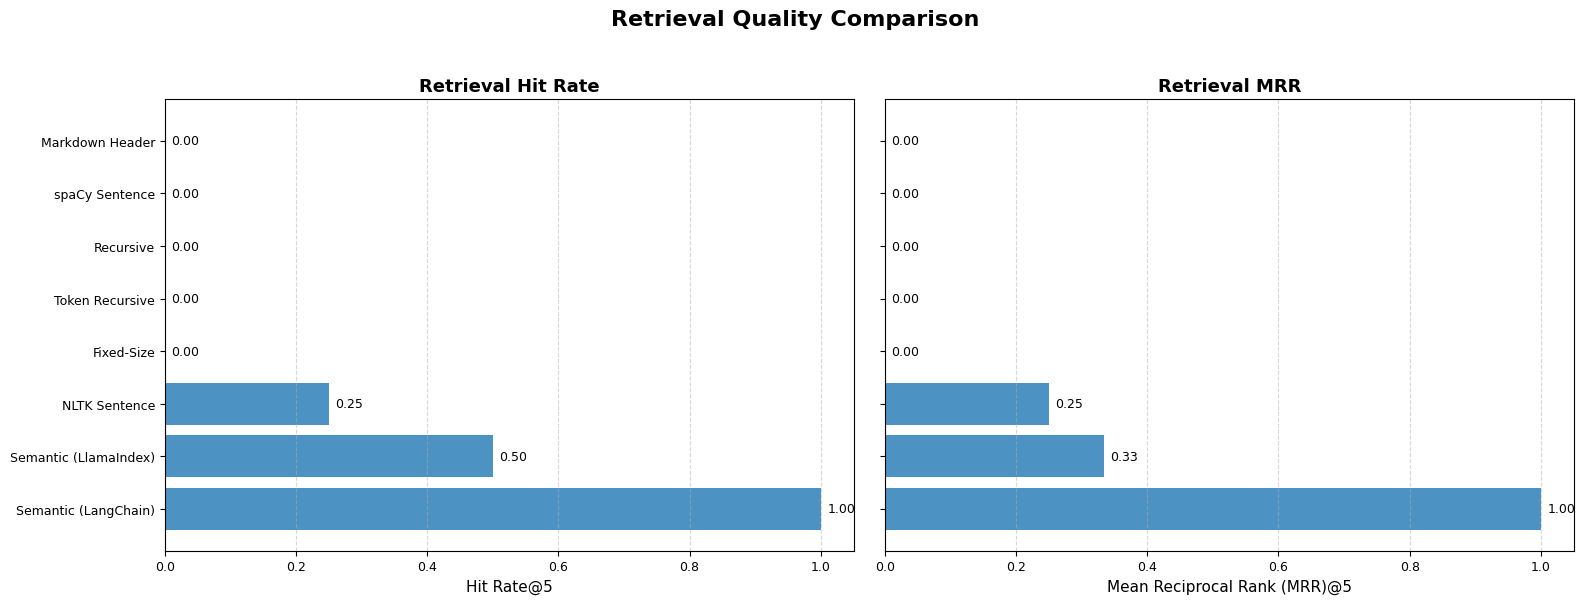


Analysis complete!


In [79]:
if __name__ == "__main__":
    # Fetch the Kubernetes Pods documentation (with injected table)
    document_text = fetch_and_prepare_data(K8S_PODS_URL)

    if not document_text:
        print("Failed to retrieve document text. Exiting.")
    else:
        # Instantiate embeddings model once
        print(f"\nLoading embedding model: {EMBEDDING_MODEL_NAME}...")
        start_load_time = time.time()
        embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL_NAME)
        print(f"Embedding model loaded in {time.time() - start_load_time:.2f}s")

        # --- Generate Automated Ground Truth ---
        print(f"\n--- Generating Automated Ground Truth using Baseline: {BASELINE_STRATEGY_NAME} ---")
        GROUND_TRUTH_CHUNK_INDICES = {}
        # Define strategies_to_run first to access the baseline function
        strategies_to_run = {
            "Fixed-Size": lambda text: chunk_fixed_size(text, TARGET_CHUNK_SIZE_CHARS, CHUNK_OVERLAP_CHARS),
            "Recursive": lambda text: chunk_recursive(text, TARGET_CHUNK_SIZE_CHARS, CHUNK_OVERLAP_CHARS),
            "Token Recursive": lambda text: chunk_tokens_recursive(text, TOKENIZER_NAME, TARGET_CHUNK_SIZE_TOKENS, CHUNK_OVERLAP_TOKENS),
            "NLTK Sentence": lambda text: chunk_sentences_nltk(text, TARGET_CHUNK_SIZE_CHARS),
            "spaCy Sentence": lambda text: chunk_sentences_spacy(text, TARGET_CHUNK_SIZE_CHARS),
            "Semantic (LangChain)": lambda text: chunk_semantic_langchain(text, EMBEDDING_MODEL_NAME),
            "Semantic (LlamaIndex)": lambda text: chunk_semantic_llamaindex(text, EMBEDDING_MODEL_NAME),
            "Markdown Header": lambda text: chunk_markdown_header(text),
        }

        try:
            # 1. Get baseline chunking function
            baseline_chunk_func = strategies_to_run.get(BASELINE_STRATEGY_NAME)
            if not baseline_chunk_func:
                raise ValueError(f"Baseline strategy '{BASELINE_STRATEGY_NAME}' not found in strategies_to_run.")

            # 2. Generate baseline chunks
            print(f"  Running baseline chunking ({BASELINE_STRATEGY_NAME})...")
            baseline_chunks = baseline_chunk_func(document_text)
            if not baseline_chunks:
                 raise ValueError("Baseline chunking produced no chunks.")
            print(f"  Generated {len(baseline_chunks)} baseline chunks.")

            # 3. Embed baseline chunks
            print("  Embedding baseline chunks...")
            baseline_embeddings = embeddings.embed_documents(baseline_chunks)
            baseline_embeddings_np = np.array(baseline_embeddings).astype('float32')
            if baseline_embeddings_np.ndim == 1: # Handle potential single chunk case
                 baseline_embeddings_np = baseline_embeddings_np.reshape(1, -1)
            if baseline_embeddings_np.shape[0] != len(baseline_chunks):
                 raise ValueError(f"Number of baseline embeddings ({baseline_embeddings_np.shape[0]}) != number of chunks ({len(baseline_chunks)}).")

            # 4. Build FAISS index for baseline
            print("  Building FAISS index for baseline...")
            baseline_dimension = baseline_embeddings_np.shape[1]
            baseline_index = faiss.IndexFlatL2(baseline_dimension)
            baseline_index.add(baseline_embeddings_np)

            # 5. Embed queries
            print("  Embedding queries...")
            query_embeddings = embeddings.embed_documents(SAMPLE_QUERIES)
            query_embeddings_np = np.array(query_embeddings).astype('float32')
            if query_embeddings_np.ndim == 1: # Handle potential single query case
                 query_embeddings_np = query_embeddings_np.reshape(1, -1)

            # 6. Search baseline index and create map
            print(f"  Searching baseline chunks to generate ground truth map (Top {AUTO_GROUND_TRUTH_TOP_N})...")
            for i, query_embedding in enumerate(query_embeddings_np):
                distances, indices = baseline_index.search(np.array([query_embedding]), AUTO_GROUND_TRUTH_TOP_N)
                # Ensure indices are valid before adding
                valid_indices = [int(idx) for idx in indices[0] if idx != -1] # Convert to int
                GROUND_TRUTH_CHUNK_INDICES[i] = valid_indices
            print("  Automated ground truth map generated.")
            # Optional: Print the generated map for inspection
            print("  Generated Map:", GROUND_TRUTH_CHUNK_INDICES)

        except Exception as e_auto_gt:
            print(f"  ERROR generating automated ground truth: {e_auto_gt}")
            import traceback
            traceback.print_exc()
            print("  Proceeding without retrieval evaluation or using empty ground truth.")
            GROUND_TRUTH_CHUNK_INDICES = {} # Ensure it's defined but empty on error
                # Store results
        stats_results = []
        retrieval_results = []
        all_chunks_dict = {} # To potentially pass to boundary visualization

        # Run each strategy and collect results
        for name, chunk_func in strategies_to_run.items():
            print(f"\n>>> Processing: {name} <<<")
            start_time = time.time()
            chunks = chunk_func(document_text)
            duration = time.time() - start_time
            print(f"  Completed in {duration:.2f} seconds.")

            all_chunks_dict[name] = chunks # Store chunks

            # Collect Stats
            stats = collect_statistics(name, chunks, duration)
            stats_results.append(stats)
            print(f"  Generated {stats['ChunkCount']} chunks.")

            # Print Samples (includes table check)
            print_sample_chunks(name, chunks)

            # Evaluate Retrieval Quality
            if GROUND_TRUTH_CHUNK_INDICES: # Check if the dictionary is not empty
              retrieval_eval = evaluate_retrieval_quality(
                name,
                chunks,
                embeddings,
                SAMPLE_QUERIES,
                GROUND_TRUTH_CHUNK_INDICES, # Use the populated map
                RETRIEVAL_K
              )
              retrieval_results.append(retrieval_eval)
            else:
              # Append placeholder results if ground truth generation failed
              print(f"  Skipping retrieval evaluation for {name} due to ground truth generation error.")
              retrieval_results.append({
                  "Strategy": name,
                  "HitRate": np.nan, # Use NaN for missing data
                  "MRR": np.nan,
                  "AvgRetrievedLength": np.nan,
                  "RetrievedChunks": {},
                  "Notes": "Ground truth error"
              })
                    # Create DataFrames
        stats_df = pd.DataFrame(stats_results)
        retrieval_df = pd.DataFrame(retrieval_results)

        # Display Summary Statistics Table (including Duration)
        summary_table = stats_df[['Strategy', 'ChunkCount', 'MinLength', 'MaxLength', 'MeanLength', 'StdDevLength', 'Duration']].copy()
        summary_table["MeanLength"] = summary_table["MeanLength"].round(1)
        summary_table["StdDevLength"] = summary_table["StdDevLength"].round(1)
        summary_table["Duration"] = summary_table["Duration"].round(2)
        print("\n--- Summary Chunking Statistics ---")
        print(summary_table.to_string(index=False))

        # Display Retrieval Statistics Table
        retrieval_summary = retrieval_df[['Strategy', 'HitRate', 'MRR', 'AvgRetrievedLength', 'Notes']].copy()
        retrieval_summary["HitRate"] = retrieval_summary["HitRate"].round(2)
        retrieval_summary["MRR"] = retrieval_summary["MRR"].round(2)
        retrieval_summary["AvgRetrievedLength"] = retrieval_summary["AvgRetrievedLength"].round(1)
        print("\n--- Summary Retrieval Statistics ---")
        print(retrieval_summary.to_string(index=False))

        # Generate Visualizations
        print("\nGenerating chunk statistics histograms...")
        plot_histograms(stats_df)

        print("\nGenerating chunk statistics box plots...")
        plot_boxplots(stats_df)

        print("\nGenerating strategy comparison plots (Length, Count, Duration)...")
        plot_strategy_comparison(stats_df)

        print("\nGenerating chunk size variation plots...")
        plot_chunk_size_variation(stats_df)

        print("\nGenerating retrieval quality comparison plots...")
        plot_retrieval_comparison(retrieval_df)

        print("\nAnalysis complete!")

------------------------------------------------------------------------

## 7. Insights & Key Takeaways

### 7.1 Understanding the Results

The analysis in this notebook provides several key insights for
technical leaders:

1.  **Chunking Strategy Impact**: Different chunking strategies
    significantly impact both the processing time and retrieval quality
    of RAG systems.

2.  **Performance Tradeoffs**: There is a clear tradeoff between
    chunking sophistication and computational cost:

    -   Fixed-size chunking is fastest but often has lower retrieval
        accuracy
    -   Semantic chunking tends to have better retrieval quality but
        higher computational costs
    -   Token-based chunking provides a good balance for LLM-specific
        implementation

3.  **Content Structure Awareness**: Structure-aware chunking methods
    (like Markdown Header) preserve content organization but may create
    irregular chunk sizes.

4.  **Business Considerations**:

    -   For production systems with high throughput needs, optimizing
        chunking strategy can significantly reduce costs
    -   For accuracy-critical applications, more sophisticated chunking
        methods may justify their additional computational overhead
    -   The right chunking strategy depends on your specific content
        types, query patterns, and business priorities

### 7.2 Implementation Recommendations

Based on this analysis, consider these implementation recommendations:

1.  **For time-sensitive applications**: Use optimized recursive token
    chunking
2.  **For maximal accuracy**: Use semantic chunking with appropriate
    tuning
3.  **For structured content**: Use structure-aware methods when
    document format is consistent
4.  **For balanced approach**: Token-based recursive chunking provides
    good performance with LLM alignment

### 7.3 Next Steps

To implement these findings in your organization:

1.  Conduct similar analysis on your specific content types
2.  Benchmark against your most common query types
3.  Consider hybrid approaches for different content categories
4.  Build monitoring for retrieval quality in production
5.  Establish a testing framework to validate chunking improvements

------------------------------------------------------------------------

## 8. About the Author

### Saumil Srivastava

**AI Engineering Consultant**

I specialize in helping engineering leaders, CTOs, and product managers
implement effective AI solutions that deliver measurable business value.
My expertise spans:

-   **AI Implementation & Architecture**
    -   Technical architecture design for AI systems
    -   ML pipeline development and optimization
    -   Migration from experimental to production environments
-   **AI Engineering Performance Optimization**
    -   Latency reduction and throughput improvement
    -   Cost optimization for LLM applications
    -   Scaling and reliability engineering
-   **ROI-Driven AI Engineering**
    -   Business value measurement frameworks
    -   Implementation prioritization methodologies
    -   Build vs. buy decision frameworks

My clients choose me because I provide: 
1. Implementation expertise that bridges theory and practice   
2. Architectural solutions that balance innovation with reliability  
3. Business-focused approaches that deliver measurable ROI 
4. Clear communication that translates between technical and business stakeholders

**Connect with me:** - Website:
[saumilsrivastava.ai](https://saumilsrivastava.ai) - LinkedIn:
[in/saumilsrivastava](https://linkedin.com/in/saumilsrivastava) - Email:
<saumil@saumilsrivastava.ai>

------------------------------------------------------------------------


For more information on how I can help your organization optimize AI
implementations, please visit
[saumilsrivastava.ai/book-consultation](https://www.saumilsrivastava.ai/book-consultation).